# Transfer Learning with PyTorch using Azure Machine Learning

In [2]:
import os, random
import azureml
import shutil
import urllib.request
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import cv2
import urllib3 
import zipfile

from azureml.core.model import Model, InferenceConfig
from azureml.core import Workspace, Datastore, Experiment, Run, Environment, ScriptRunConfig

from azureml.core.compute import ComputeTarget, AmlCompute, AksCompute, ComputeTarget
from azureml.train.dnn import PyTorch
from azureml.widgets import RunDetails

from azureml.core.webservice import Webservice, AksWebservice, AciWebservice
from azureml.core.dataset import Dataset
from azureml.core.resource_configuration import ResourceConfiguration
from azureml.core.conda_dependencies import CondaDependencies 

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.27.0


## 1 - Connect to the AML Workspace Environment

In [3]:
# Connect to workspace
# config.json file expected in ./azureml directory
# config.json can be generated from the azure portal while browsing the workspace
ws = Workspace.from_config()
print("Workspace:",ws.name)

# Connect to compute for training
# compute target must belong to the workspace AND compute targets are limited by the workspace region
# there may be ability to do cross workspace compute targets in the future
compute_target = ComputeTarget(workspace=ws, name="AzPytrch-NC6")
print("Compute Target:",compute_target.name)

# Connect to the datastore for the training images
# datastore must be associated with storage account belonging to workspace
ds = Datastore.get_default(ws)
print("Datastore:",ds.name)

# Connect to the experiment
exp = Experiment(workspace=ws, name='ANFIS-PyTorch')
print("Experiment:",exp.name)

Workspace: AzureML-Pytorch
Compute Target: AzPytrch-NC6
Datastore: workspaceblobstore
Experiment: ANFIS-PyTorch


## 2 - Data
### 2.1 Upload the data to AML datastore

In [4]:
# Upload all the data to the datastore
# will upload all files and subdirectories in data_path
data_path = "./ANFIS-data/"  
ds.upload(src_dir=data_path, target_path='ANFIS-data', overwrite=True, show_progress=True)

Uploading an estimated of 3 files
Uploading ./ANFIS-data\ANFIS.csv
Uploaded ./ANFIS-data\ANFIS.csv, 1 files out of an estimated total of 3
Uploading ./ANFIS-data\Train\ANFIS-Train.csv
Uploaded ./ANFIS-data\Train\ANFIS-Train.csv, 2 files out of an estimated total of 3
Uploading ./ANFIS-data\Val\ANFIS-val.csv
Uploaded ./ANFIS-data\Val\ANFIS-val.csv, 3 files out of an estimated total of 3
Uploaded 3 files


$AZUREML_DATAREFERENCE_e5279f859a674394bdc0d84ecabf7078

### 2.2 Create a Dataset 

In [9]:
# create a FileDataset pointing to files in 'ANFIS-data' folder and its subfolders recursively
datastore_paths = [(ds, 'ANFIS-data')]
print(datastore_paths)
ANFIS_ds = Dataset.File.from_files(path=datastore_paths)


# Register the dataset in AMLS
ANFIS_ds.register(workspace=ws,
             name='ANFIS-data',
             description='Data to be modeled with ANFIS',
             create_new_version = True)

# OR you can connect to existing / previous version of the data
#ANFIS_ds = Dataset.get_by_name(ws, name='ANFIS-data')

[({
  "name": "workspaceblobstore",
  "container_name": "azureml-blobstore-37cc9333-cffe-4a2a-ba89-7ed5c59dd573",
  "account_name": "azuremlpytorch4611169748",
  "protocol": "https",
  "endpoint": "core.windows.net"
}, 'ANFIS-data')]


{
  "source": [
    "('workspaceblobstore', 'ANFIS-data')"
  ],
  "definition": [
    "GetDatastoreFiles"
  ],
  "registration": {
    "id": "cafb8ec9-4099-48ba-81db-3e895cb12680",
    "name": "ANFIS-data",
    "version": 2,
    "description": "Data to be modeled with ANFIS",
    "workspace": "Workspace.create(name='AzureML-Pytorch', subscription_id='64c7fe17-2a05-4aed-ac0a-b82f18a992da', resource_group='Testing')"
  }
}

## 3 - Train the model
### 3.1 Training scripts

In [16]:
# All training scripts are stored locally in ./ANFIS-scripts/
# These scripts will be wrapped in a container by Script Run Config below 
# Training scripts will be published to the VM 
#    616_ANFIS.py (training script)
#    anfis.py (defines ANFIS model)
#    membership.py (membership functions)
#    experimental.py (controls experiments)

# Training scripts can be written in pure python/pytorch
# Training scripts do not need to reference the azureml sdk
# BUT training scripts will have to access the azureml sdk to conduct logging
#    from azureml.core import Run
#    run = Run.get_context()  ### Add run context for AML
#    run.log("{} Loss".format(phase), np.float(epoch_loss))
#    run.log("{} Acc".format(phase), np.float(epoch_acc))

# arguments can be passed to training script 
# they have to be parsed in the training script
#    import argparse
#    parser = argparse.ArgumentParser()
#    parser.add_argument("--data-folder", type=str, dest="data_folder", help="data folder mounting point", default="")
#    parser.add_argument("--num-epochs", type=int, dest="num_epochs", help="Number of epochs", default="")
#    args = parser.parse_args()
#    data_path = args.data_folder

# The file mounts for datasets in the VM will be (something like)
#    data_path = /mnt/batch/tasks/shared/LS_root/jobs/azureml-pytorch/azureml/ANFIS-pytorch_1620012816_f08ea422/wd/tmpjdv3v5lk/


### 3.2 Create and run a PyTorch ScriptRunConfig

In [57]:
#Create Script Run Config

# Use an Azure curated environment to create docker container
curated_env_name = 'AzureML-PyTorch-1.6-GPU'

pytorch_env = Environment.get(workspace=ws, name=curated_env_name)
pytorch_env = pytorch_env.clone(new_name='pytorch-1.6-gpu')

# OR 
# use build the conda environment used on local machine (from a python terminal) to create docker container
# build yml file with 'conda env export -n [name of environment] -f [filename.yml]'
# place yml file in the ./azureml directory

# pytorch_env = Environment.from_conda_specification(
#         name='AzurePytorch',
#         file_path='./.azureml/AzurePytorch.yml'
#     )



# arguments can be passed to training script 
# they have to be parsed in the training script
#    import argparse
#    parser = argparse.ArgumentParser()
#    parser.add_argument("--data-folder", type=str, dest="data_folder", help="data folder mounting point", default="")
#    parser.add_argument("--num-epochs", type=int, dest="num_epochs", help="Number of epochs", default="")
#    args = parser.parse_args()
#    data_path = args.data_folder

args = [
    '--data-folder', ANFIS_ds.as_named_input('ANFIS').as_mount(),
    '--num-epochs', 50000
]

project_folder = "./ANFIS-scripts"  # this refers to local location of scripts, these scripts will be built into docker container

# Script Run Config defines the wrapper for the python scripts and will be used to create the Docker container
config = ScriptRunConfig(
    source_directory = project_folder, 
    script = '616_ANFIS.py', 
    compute_target=compute_target,
    environment = pytorch_env,
    arguments=args,
)
print('done')

done


In [58]:
# Run script
# This command can take a long time to run the first time
# Docker container will be built and published and compute cores may have to be started
# Subsequent runs will be faster
run = exp.submit(config)
# Show the PyTorch estimator widget
RunDetails(run).show()





_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

### 3.3 Register the model in Azure ML

In [62]:

# Load a historic run (i.e. last run)

r = list(exp.get_runs())   # Experiment.get_runs() returns a generator that enumerates runs in chronologica order
lastrun = r[0]      # get last run
# RunDetails(run).show()

model = lastrun.register_model(model_name='ANFIS-PyTorch',
                           model_path='outputs',
                           model_framework='PyTorch',
                           model_framework_version='1.6',
                           description="ANFIS PyTorchmodel",
                           tags={'ANFIS':'Pytorch'},
                           resource_configuration=ResourceConfiguration(cpu=1, memory_in_gb=2))

print("Model '{}' version {} registered ".format(model.name,model.version))

Model 'ANFIS-PyTorch' version 1 registered 


### 3.4 Download & Test the model

In [63]:
model.download(exist_ok=True)

'outputs\\model.pth'

In [85]:
print(os.path)
ss = os.path.join('ANFIS_scripts', 'model.pth')



sys.path.append('/ANFIS_scripts')
print(sys.path)

<module 'ntpath' from 'C:\\Users\\gkurp\\.conda\\envs\\AzurePytorch\\lib\\ntpath.py'>
['c:\\Users\\gkurp\\OneDrive\\Documents\\Education\\Code\\azml-test', 'c:\\Users\\gkurp\\.vscode\\extensions\\ms-toolsai.jupyter-2021.5.745244803\\pythonFiles', 'c:\\Users\\gkurp\\.vscode\\extensions\\ms-toolsai.jupyter-2021.5.745244803\\pythonFiles\\lib\\python', 'C:\\Users\\gkurp\\.conda\\envs\\AzurePytorch\\python38.zip', 'C:\\Users\\gkurp\\.conda\\envs\\AzurePytorch\\DLLs', 'C:\\Users\\gkurp\\.conda\\envs\\AzurePytorch\\lib', 'C:\\Users\\gkurp\\.conda\\envs\\AzurePytorch', '', 'C:\\Users\\gkurp\\.conda\\envs\\AzurePytorch\\lib\\site-packages', 'C:\\Users\\gkurp\\.conda\\envs\\AzurePytorch\\lib\\site-packages\\win32', 'C:\\Users\\gkurp\\.conda\\envs\\AzurePytorch\\lib\\site-packages\\win32\\lib', 'C:\\Users\\gkurp\\.conda\\envs\\AzurePytorch\\lib\\site-packages\\Pythonwin', 'C:\\Users\\gkurp\\.conda\\envs\\AzurePytorch\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\gkurp\\.ipython', 'C:\\Us

In [87]:
import os
import torch
import torch.nn as nn

# sys.path.append('/.../application/app/folder')
# sys.path.append('/ANFIS_scripts')
# print(sys.path)

import ANFIS_scripts.anfis
from .ANFIS_scripts import membership

import json
import urllib

# Load the model
loaded_model = torch.load(os.path.join('outputs','model.pth'), map_location=lambda storage, loc: storage)
loaded_model.eval()

SyntaxError: invalid syntax (<ipython-input-87-d956e6ecb039>, line 10)

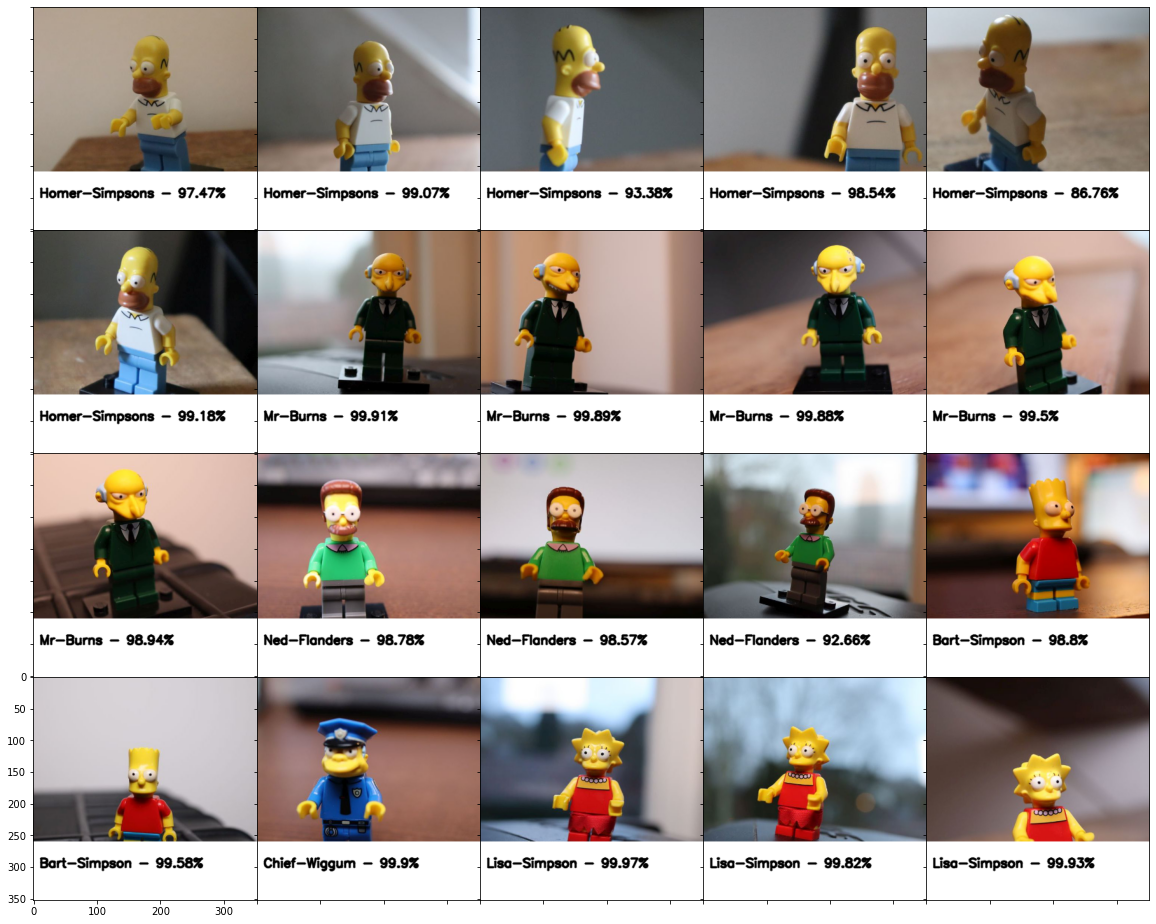

In [37]:


# Load the labels
with open(os.path.join('outputs','labels.txt'), 'rt') as lf:
    global labels
    labels = [l.strip() for l in lf.readlines()]

    
def scoreImage(image_link):
    # Load the image to predict
    input_image = Image.open(image_link)

    # Pre process
    preprocess = transforms.Compose([
        transforms.Resize(225),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    # Predict the image
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        loaded_model.to('cuda')

    with torch.no_grad():
        output = loaded_model(input_batch)

    index = output.data.cpu().numpy().argmax()
    probability = torch.nn.functional.softmax(output[0], dim=0).data.cpu().numpy().max()

    #Return the result
    return {"label": labels[index], "probability": round(probability*100,2)}



path = r"data/test"
grid = AxesGrid(plt.figure(1, (20,20)), 111, nrows_ncols=(4, 5), axes_pad=0, label_mode="1")

i = 0
for img in os.listdir(path):
    
    #Score the image
    result = scoreImage(os.path.join(path,img))
    
    # Download image
    image = cv2.imread(os.path.join(path,img))
    image = cv2.resize(image, (352, 352))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    cv2.rectangle(image, (0,260),(352,352),(255,255,255), -1)
    cv2.putText(image, "{} - {}%".format(result['label'],result['probability']),(10, 300), cv2.FONT_HERSHEY_SIMPLEX, 0.65,(0,0,0),2,cv2.LINE_AA)    
    
    # Show image in grid
    grid[i].imshow(image)
    i = i+1

## 4 Deploy the model

### 4.1 Create a scoring script

In [38]:
%%writefile 'score.py'
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import json
import urllib
from PIL import Image

from azureml.core.model import Model

def init():
    global model
    model_path = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'outputs','model.pth')
    labels_path = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'outputs','labels.txt')
    
    print('Loading model...', end='')
    model = torch.load(model_path, map_location=lambda storage, loc: storage)
    model.eval()
    
    print('Loading labels...', end='')
    with open(labels_path, 'rt') as lf:
        global labels
        labels = [l.strip() for l in lf.readlines()]
    print(len(labels), 'found. Success!')

    
def run(input_data):
    url = json.loads(input_data)['url']
    urllib.request.urlretrieve(url, filename="tmp.jpg")
    
    input_image = Image.open("tmp.jpg")

    preprocess = transforms.Compose([
        transforms.Resize(225),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)

    index = output.data.cpu().numpy().argmax()
    probability = torch.nn.functional.softmax(output[0], dim=0).data.cpu().numpy().max()

    result = {"label": labels[index], "probability": round(probability*100,2)}
    os.remove("tmp.jpg")
    return result

Writing score.py


### 4.2 Create an environment file

In [39]:
myenv = Environment(name="simpsons-inference")

conda_dep = CondaDependencies()

# Define the packages needed by the model and scripts
#conda_dep.add_conda_package("tensorflow")
#conda_dep.add_conda_package("numpy")
#conda_dep.add_conda_package("scikit-learn")

# You must list azureml-defaults as a pip dependency
conda_dep.add_pip_package("azureml-defaults")
conda_dep.add_pip_package("torch")
conda_dep.add_pip_package("torchvision")
conda_dep.add_pip_package("pillow==5.4.1")

# Adds dependencies to PythonSection of myenv
myenv.python.conda_dependencies=conda_dep



### 4.3 Create an Inference config

In [40]:
inference_config = InferenceConfig(
    entry_script="score.py", 
    environment=myenv
)

### 4.4 Deploy to ACI

In [41]:
model = Model(ws, name='Simpsons-PyTorch')
print("Loaded model version:",model.version)

Loaded model version: 1


In [42]:
# Create a deployment config
deploy_config = AciWebservice.deploy_configuration(
                    cpu_cores = model.resource_configuration.cpu, 
                    memory_gb = model.resource_configuration.memory_in_gb,
                    description='Simpson Lego Classifier')

In [43]:
# Deploy the model to an ACI
aci_service = Model.deploy(ws, 
                name="simpsons-pt-aci", 
                models = [model], 
                inference_config = inference_config, 
                deployment_config = deploy_config, 
                overwrite = True)

aci_service.wait_for_deployment(show_output=True)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-05-01 22:33:56-04:00 Creating Container Registry if not exists..
2021-05-01 22:34:06-04:00 Registering the environment.
2021-05-01 22:34:07-04:00 Building image..
2021-05-01 22:41:08-04:00 Generating deployment configuration.
2021-05-01 22:41:09-04:00 Submitting deployment to compute..
2021-05-01 22:41:13-04:00 Checking the status of deployment simpsons-pt-aci..
2021-05-01 22:44:55-04:00 Checking the status of inference endpoint simpsons-pt-aci.
Succeeded
ACI service creation operation finished, operation "Succeeded"


In [44]:
# Connect to previous deployment
aci_service = AciWebservice(ws, "simpsons-pt-aci")

In [45]:
print("Scoring endpoint:",aci_service.scoring_uri)

Scoring endpoint: http://2ac31a6e-f2a6-4be8-b1dc-f5fa2d84d7ad.centralus.azurecontainer.io/score


### 4.4 Deploy to Azure Kuberneter Service

In [48]:
aks_target = AksCompute(ws,"AzureML-Test-Compute")

deployment_config = AksWebservice.deploy_configuration(
    cpu_cores = 2, 
    memory_gb = 8)

aks_service = Model.deploy(workspace=ws, 
                       name="simpsons-pytorch-test-6", 
                       models=[model], 
                       inference_config=inference_config, 
                       deployment_config=deployment_config, 
                       deployment_target=aks_target,
                       overwrite=True)

aks_service.wait_for_deployment(show_output = True)

WebserviceException: WebserviceException:
	Message: Unsupported ClusterType BatchAI for the Compute resource Id 'AzureML-Test-Compute'.
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "Unsupported ClusterType BatchAI for the Compute resource Id 'AzureML-Test-Compute'."
    }
}

In [ ]:
### Connect to a previous deployed service
aks_service = [r for r in AksWebservice.list(ws) if r.name == 'simpsons-pytorch'][0]

In [ ]:
print(aks_service.scoring_uri)
aks_service.get_keys()

### 4.4 Test the API

In [ ]:
%%writefile 'test-images-urls.txt'
https://raw.githubusercontent.com/hnky/dataset-lego-figures/master/_test/Krusty.jpg
https://raw.githubusercontent.com/hnky/dataset-lego-figures/master/_test/Bart.jpg
https://raw.githubusercontent.com/hnky/dataset-lego-figures/master/_test/Flanders.jpg
https://raw.githubusercontent.com/hnky/dataset-lego-figures/master/_test/Homer.jpg
https://raw.githubusercontent.com/hnky/dataset-lego-figures/master/_test/Lisa.jpg
https://raw.githubusercontent.com/hnky/dataset-lego-figures/master/_test/marge.jpg
https://raw.githubusercontent.com/hnky/dataset-lego-figures/master/_test/Milhouse.jpg
https://raw.githubusercontent.com/hnky/dataset-lego-figures/master/_test/MrBurns.jpg
https://raw.githubusercontent.com/hnky/dataset-lego-figures/master/_test/Wiggum.jpg

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from PIL import Image as ImagePil
import requests
from io import BytesIO
import cv2
import urllib
import cv2
import numpy as np
import json

F = plt.figure(1, (20,20))
grid = AxesGrid(F, 111, nrows_ncols=(2, 3), axes_pad=0, label_mode="1")

with open('test-images-urls.txt', 'rt') as lf:
    global testimages
    testimages = [l.strip() for l in lf.readlines()]
    
def url_to_image(url):
    with urllib.request.urlopen(url) as url:
        s = url.read()
    image = np.asarray(bytearray(s), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (352, 352))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


i = 0
for img_name in testimages[0:6]:
    
    # Predict Url ACI
    #result = aci_service.run(input_data=json.dumps({ "url": img_name}))
    
    # Predict Url AKS
    result = aks_service.run(input_data=json.dumps({ "url": img_name}))

    # Download image
    img = url_to_image(img_name)
 
    # Draw result on image
    cv2.rectangle(img, (0,260),(352,352),(255,255,255), -1)
    cv2.putText(img, "{} - {}%".format(result['label'],result['probability']),(10, 300), cv2.FONT_HERSHEY_SIMPLEX, 0.65,(0,0,0),2,cv2.LINE_AA)

    # Show image in grid
    grid[i].imshow(img)
    i = i+1

In [ ]:
with open('test-images-urls.txt', 'rt') as lf:
    global testimages
    testimages = [l.strip() for l in lf.readlines()]

print(testimages)